In [2]:
import sys
sys.path.append("..")
from IPython.display import SVG
import keras
import keras.layers as L
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from models import autoencoderV6
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, load_kabat, vdw_data, charge_index_data
from utils.defines import VL_LENGTH, VH_LENGTH
import os
import tensorflow as tf
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto(device_count={'GPU': 1})
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [48]:
data = np.load('../data/pssm_results/igembl_BLOSUM62_result.npy')

In [49]:
data.shape

(2307, 140, 40)

In [50]:
MAX_LENGTH=data.shape[1]
RNN = L.CuDNNLSTM
input_dims = (MAX_LENGTH, 21)

def get_loss(mask_value):
    mask_value = K.variable(mask_value, dtype=K.floatx())
    def masked_categorical_crossentropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character '#'
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())
        
        # multiply categorical_crossentropy with the mask
        loss = K.categorical_crossentropy(y_true, y_pred) * mask

        # take average w.r.t. the number of unmasked entries
        return K.sum(loss) / K.sum(mask)
    return masked_categorical_crossentropy

def get_accuracy(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.variable(mask_value, dtype=K.floatx())

    def masked_acc(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())

        acc = K.cast(K.equal(K.argmax(y_true,-1),  K.argmax(y_pred,-1)), K.floatx()) * mask

        # take average w.r.t. the number of unmasked entries
        return K.sum(acc) / K.sum(mask)

    return masked_acc

masked_acc = get_accuracy(0)
masked_loss = get_loss(0)

In [129]:
def autoencoderV6(input_dims, latent_dim=2, cuda_device=0, RNN_cell='GRU', compile=True):

    """


    :param input_dims:
    :param latent_dim:
    :param cuda_device:
    :param RNN_cell:
    :param compile:
    :return:
    """

    VL_input = L.Input(input_dims, dtype='float', name='VL_INPUT')
    VH_input = L.Input(input_dims, dtype='float', name='VH_INPUT')

    def encoder(inputs):

        # define first recurrent layers
        rnn_vl = RNN(32, name='VL_RNN')(inputs[0])
        rnn_vh = RNN(32, name='VH_RNN')(inputs[1])

        # first dense layer of encoder
        dense_1_vl = L.Dense(16, activation='relu', name='VL_encoder_dense_1')(rnn_vl)
        dense_1_vh = L.Dense(16, activation='relu', name='VH_encoder_dense_1')(rnn_vh)

        # merge dense layers: concatenate [dense_1_vl, dense_1_vh]
        merge_layer = L.merge.concatenate([dense_1_vl, dense_1_vh], name='merge_layer')

        # add another layer to combine features from VL and VH
        dense_1 = L.Dense(32, activation='relu', name='merged_encoder_dense_1')(merge_layer)

        # combine dense_1 output to learn a lower dimension latent vector
        bottleneck = L.Dense(latent_dim, name='bottleneck')(dense_1)

        # encoder_model = keras.Model([VL_input, VH_input], bottleneck, name='encoder')

        return bottleneck

    def decoder(encoder_layer):

        dense_r_1 = L.Dense(32, activation='relu', name='merged_decoder_dense1')(encoder_layer)

        dense_r_2 = L.Dense(32, activation='relu', name='merged_decoder_dense2')(dense_r_1)

        outputs = []

        for name, length in zip(['VL', 'VH'], [input_dims[0], input_dims[0]]):
            dense_r_3 = L.Dense(16, activation='relu', name='{}_decoder_dense1'.format(name))(dense_r_2)

            repeat_vector_r_1 = L.RepeatVector(length, name='{}_decoder_repeatvector1'.format(name))(dense_r_3)

            rnn_r = RNN(32, return_sequences=True, name='{}_decoder_rnn1'.format(name))(repeat_vector_r_1)

            output_r = L.Dense(input_dims[1], name='{}_output'.format(name))(rnn_r)

            outputs.append(output_r)

        return outputs

    code = encoder([VL_input, VH_input])
    reconstruction = decoder(code)

    autoencoder = keras.models.Model(inputs=[VL_input, VH_input], outputs=reconstruction)
    encoder_model = keras.models.Model(inputs=[VL_input, VH_input], outputs=code)

    if compile:
        masked_mse = get_loss(0)
        autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=masked_mse)

    return encoder_model, autoencoder, sess

In [130]:
VL_X = data[1::2,:,:20]
VH_X = data[::2,:,20:][:-1]

In [131]:
VL_X.shape

(1153, 140, 20)

In [132]:
VH_X.shape

(1153, 140, 20)

In [133]:
encoder_model, autoencoder, _ = autoencoderV6((140,20), compile=False)

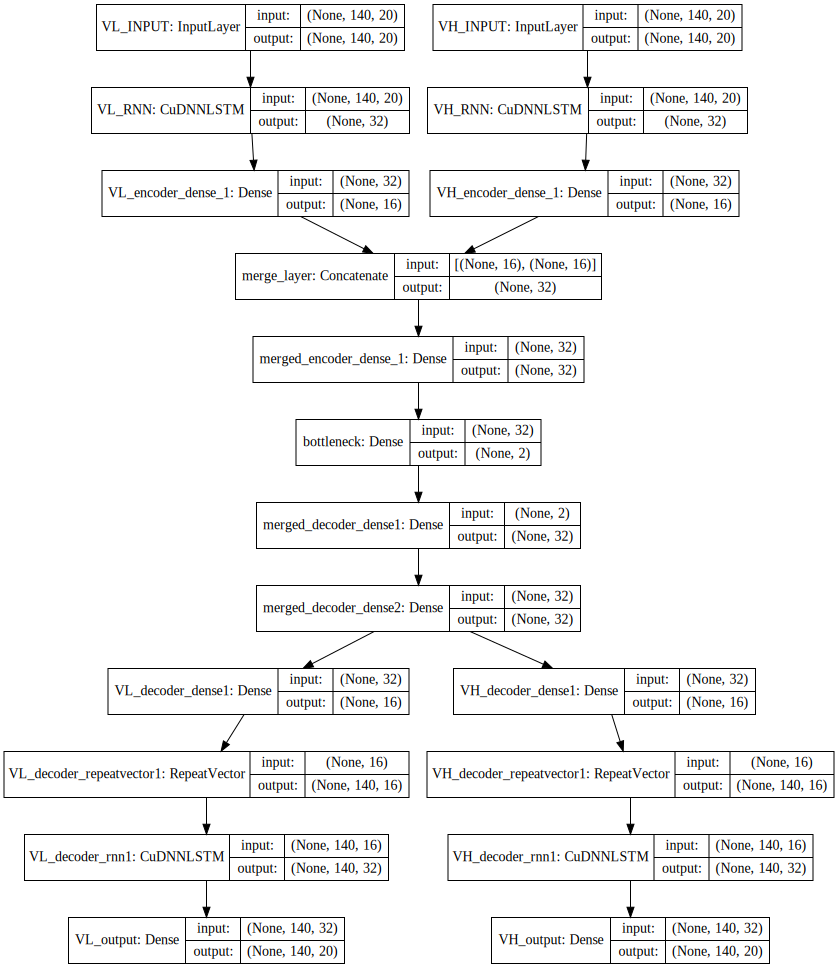

In [134]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [135]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=masked_loss)

In [136]:
autoencoder.fit([VL_X, VH_X], [VL_X, VH_X], batch_size=16, epochs=25, validation_split=0.2)

Train on 922 samples, validate on 231 samples
Epoch 1/25
922/922 [==============================] - 3s 3ms/step - loss: 54.4939 - VL_output_loss: 8.7874 - VH_output_loss: 45.7065 - val_loss: 65.9953 - val_VL_output_loss: 9.4672 - val_VH_output_loss: 56.5280
Epoch 2/25
922/922 [==============================] - 1s 1ms/step - loss: 58.6657 - VL_output_loss: 8.8539 - VH_output_loss: 49.8118 - val_loss: 57.7502 - val_VL_output_loss: 6.8567 - val_VH_output_loss: 50.8935
Epoch 3/25
922/922 [==============================] - 1s 1ms/step - loss: 61.2831 - VL_output_loss: 10.8697 - VH_output_loss: 50.4135 - val_loss: 68.9906 - val_VL_output_loss: 11.1753 - val_VH_output_loss: 57.8153
Epoch 4/25
922/922 [==============================] - 1s 1ms/step - loss: 63.2366 - VL_output_loss: 11.1533 - VH_output_loss: 52.0833 - val_loss: 67.7247 - val_VL_output_loss: 11.1843 - val_VH_output_loss: 56.5403
Epoch 5/25
922/922 [==============================] - 1s 1ms/step - loss: 67.9041 - VL_output_loss: 11

In [137]:
code = encoder_model.predict([VL_X, VH_X])

In [138]:
from matplotlib import pyplot as plt
%matplotlib inline

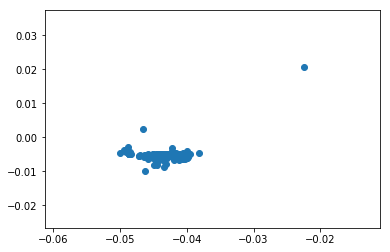

In [139]:
plt.scatter(code[:,0], code[:,1])

In [141]:
VH_X[0]

array([[0.28842371, 0.70890462, 0.5       , ..., 0.13954358, 0.28576668,
        0.14110965],
       [0.60441754, 0.07605449, 0.06893404, ..., 0.06243524, 0.26716992,
        0.96039172],
       [0.31065134, 0.61754619, 0.42118055, ..., 0.12874724, 0.28842371,
        0.23681052],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])